In [7]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import contractions
import tensorflow as tf 
tf.compat.v1.disable_v2_behavior()
import re
import string
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from collections import  Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
import pyLDAvis
import pyLDAvis.gensim 
from wordcloud import WordCloud
import os
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from imblearn.under_sampling import RandomUnderSampler
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from keras.layers import LSTM, Activation, Dropout, Dense, Input,GRU
from keras.layers.embeddings import Embedding
from keras.models import Model
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint


import warnings
warnings.filterwarnings('ignore')


Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [ ]:
df=pd.read_csv(r"twitter_parsed_dataset.csv")

df.shape

(16851, 5)

In [ ]:
df.head(5)

,index,id,Text,Annotation,oh_label
0,5.74948705591165E+017,5.74948705591165E+017,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,5.71917888690393E+017,5.71917888690393E+017,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,3.90255841338601E+017,3.90255841338601E+017,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,5.68208850655916E+017,5.68208850655916E+017,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,5.75596338802373E+017,5.75596338802373E+017,#mkr No No No No No No,none,0.0


In [ ]:
#Drop the index and id columns
df.drop(columns=['index','id','Annotation'],axis=1,inplace=True)
#Rename the columns to lower case.
df.columns = map(str.lower, df.columns)

In [ ]:
df['text'].sample(1).values[0]

'RT @PeterTownsend7: #islam #isis #muslim Muhammad and Free Speech - An explosive encounter. http://t.co/zpK2GGTwwE http://t.co/gI95GYlQEE'

In [ ]:
df.oh_label.value_counts()

0.0    11501
1.0     5347
Name: oh_label, dtype: int64

([<matplotlib.axis.XTick at 0x6464ccc3c8>,
 [Text(0, 0, 'positive'), Text(1, 0, 'negative')])

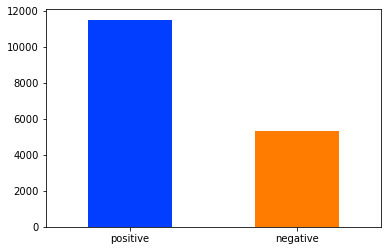

In [ ]:

df.oh_label.value_counts().plot(kind='bar', color=sns.color_palette('bright'))
plt.xticks([0,1],['positive', 'negative'], rotation=0)

<b> Observation <b>
* The dataset is imbalanced.

### Data EDA & Preprocessing (Cleaning and Inspecting)

In [ ]:
df.isna().sum()

text        1
oh_label    3
dtype: int64

In [ ]:
#Dropping the missing values
df.dropna(axis=0,inplace=True)


**<span style='color:red '>Lower case the text</span>**

In [ ]:
def lowerCase(sample):
    sample = " ".join([x.lower() for x in sample.split()])
    return sample
df['lowerCase'] = df['text'].apply(lambda x: lowerCase(x))
df.head(2)

,text,oh_label,lowerCase
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,@halalflaws @biebervalue @greenlinerzjm i read...
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,@shreyabafna3 now you idiots claim that people...


**<span style='color:red '>Remove URL</span>**


In [ ]:
def remove_url(text):
    sample = text
    sample = re.sub(r"\S*https?:\S*", '', sample) #links and urls
    return sample
df['urls_removed'] = df['lowerCase'].apply(lambda x: remove_url(x))
df.head(4)  

,text,oh_label,lowerCase,urls_removed
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,"rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ..."
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,"@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp..."



**<span style='color:red '>Remove HTML Tags </span>**

In [ ]:
def remove_html(sample):
    comp = re.compile(r'<.*?>')
    sample = re.sub(comp, '', sample)
    return sample
df['htmltag_removed'] = df['urls_removed'].apply(lambda x: remove_html(x))
df.head(4)      

,text,oh_label,lowerCase,urls_removed,htmltag_removed
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,"rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ..."
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,"@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp..."


**<span style='color:red '>Remove square brackets[] and parenthesis() </span>**

In [ ]:
def remove_sqr(sample):
    sample = re.sub(r'\[.*?\]', '', sample) #text between [square brackets]
    sample = re.sub(r'\(.*?\)', '', sample) #text between (parenthesis)
    return sample
df['square_parathensis_removed'] = df['htmltag_removed'].apply(lambda x: remove_sqr(x))
df.head(4)      

,text,oh_label,lowerCase,urls_removed,htmltag_removed,square_parathensis_removed
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,"rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ..."
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,"@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp..."


**<span style='color:red '> Fixing Contractions </span>**

In [ ]:
def contract(sample):
    sample = " ".join([contractions.fix(x) for x in sample.split()]) 
    return sample
df['contraction_fixed'] = df['square_parathensis_removed'].apply(lambda x: contract(x))
df.head(4)     

,text,oh_label,lowerCase,urls_removed,htmltag_removed,square_parathensis_removed,contraction_fixed
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,"rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ..."
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,"@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp..."


**<span style='color:red '> Remove punctuation </span>**

In [ ]:
def remove_punctuations(sample):
   
    sample = re.sub(r'[%s]' % re.escape(string.punctuation), '', sample) #punctuations
    sample = re.sub(r"[''""...“”‘’…]", '', sample) #list of quotation marks
    return sample
df['punc_removed'] = df['contraction_fixed'].apply(lambda x: remove_punctuations(x))
df.head(4)     

,text,oh_label,lowerCase,urls_removed,htmltag_removed,square_parathensis_removed,contraction_fixed,punc_removed
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...,halalflaws biebervalue greenlinerzjm i read th...
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...,shreyabafna3 now you idiots claim that people ...
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,"rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ...",rt mooseoftorment call me sexist but when i go...
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,"@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp...",g0ssipsquirrelx wrong isis follows the example...


**<span style='color:red '>Remove_non english_characters(s) and other languages</span>**

In [ ]:
nltk.download('words')
only_english = set(nltk.corpus.words.words())
 
def remove_special_characters(sample):
    sample = re.sub(r'\n', ' ', sample) #new line character
    sample = re.sub(r'\\n', ' ', sample) #new line character
    sample = ' '.join([w for w in nltk.wordpunct_tokenize(sample) if w.lower() in only_english ]) 
    sample = ' '.join(list(filter(lambda ele: re.search(r"[a-zA-Z\s]+", ele) is not None, sample.split()))) #languages other than english
    sample = " ".join([x.strip() for x in sample.split()])
    
    return sample
df['nonEnglish_removed'] = df['punc_removed'].apply(lambda x: remove_special_characters(x))
df.head(4)    

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Mohamed\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


,text,oh_label,lowerCase,urls_removed,htmltag_removed,square_parathensis_removed,contraction_fixed,punc_removed,nonEnglish_removed
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...,halalflaws biebervalue greenlinerzjm i read th...,i read them in change in meaning the history o...
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...,shreyabafna3 now you idiots claim that people ...,now you claim that people who tried to stop hi...
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,"rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ...",rt mooseoftorment call me sexist but when i go...,call me but when i go to an auto place i would...
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,"@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp...",g0ssipsquirrelx wrong isis follows the example...,wrong the example of and the exactly


**<span style='color:red '>Remove_special_characters(s) - # </span>**

In [ ]:
def remove_hashtags_only(sample):
    sample = ' '.join([x for x in sample.split() if not x.startswith('#')])
    return sample

df['hashtag_removed'] = df['nonEnglish_removed'].apply(lambda x: remove_hashtags_only(x))
df.head(4)   

,text,oh_label,lowerCase,urls_removed,htmltag_removed,square_parathensis_removed,contraction_fixed,punc_removed,nonEnglish_removed,hashtag_removed
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...,halalflaws biebervalue greenlinerzjm i read th...,i read them in change in meaning the history o...,i read them in change in meaning the history o...
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...,shreyabafna3 now you idiots claim that people ...,now you claim that people who tried to stop hi...,now you claim that people who tried to stop hi...
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,"rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ...",rt mooseoftorment call me sexist but when i go...,call me but when i go to an auto place i would...,call me but when i go to an auto place i would...
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,"@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp...",g0ssipsquirrelx wrong isis follows the example...,wrong the example of and the exactly,wrong the example of and the exactly


**<span style='color:red '>Remove_emojis </span>**

In [ ]:
def remove_emojis(sample):
    sample = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', sample) #emojis and symbols
    return sample
df['emoji_removed'] = df['hashtag_removed'].apply(lambda x: remove_emojis(x))
df.head(4)   

,text,oh_label,lowerCase,urls_removed,htmltag_removed,square_parathensis_removed,contraction_fixed,punc_removed,nonEnglish_removed,hashtag_removed,emoji_removed
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...,halalflaws biebervalue greenlinerzjm i read th...,i read them in change in meaning the history o...,i read them in change in meaning the history o...,i read them in change in meaning the history o...
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...,shreyabafna3 now you idiots claim that people ...,now you claim that people who tried to stop hi...,now you claim that people who tried to stop hi...,now you claim that people who tried to stop hi...
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,"rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ...",rt mooseoftorment call me sexist but when i go...,call me but when i go to an auto place i would...,call me but when i go to an auto place i would...,call me but when i go to an auto place i would...
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,"@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp...",g0ssipsquirrelx wrong isis follows the example...,wrong the example of and the exactly,wrong the example of and the exactly,wrong the example of and the exactly


**<span style='color:red '>Remove_digits </span>**

In [ ]:
def remove_digitsText(sample):
    sample = re.sub('[0-9]+', '', sample) #digits with trailing or preceeding text
    return sample

df['digitText_removed'] = df['emoji_removed'].apply(lambda x: remove_digitsText(x))
df.head(4) 


,text,oh_label,lowerCase,urls_removed,htmltag_removed,square_parathensis_removed,contraction_fixed,punc_removed,nonEnglish_removed,hashtag_removed,emoji_removed,digitText_removed
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...,@halalflaws @biebervalue @greenlinerzjm i read...,halalflaws biebervalue greenlinerzjm i read th...,i read them in change in meaning the history o...,i read them in change in meaning the history o...,i read them in change in meaning the history o...,i read them in change in meaning the history o...
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...,@shreyabafna3 now you idiots claim that people...,shreyabafna3 now you idiots claim that people ...,now you claim that people who tried to stop hi...,now you claim that people who tried to stop hi...,now you claim that people who tried to stop hi...,now you claim that people who tried to stop hi...
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,"rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ...","rt @mooseoftorment call me sexist, but when i ...",rt mooseoftorment call me sexist but when i go...,call me but when i go to an auto place i would...,call me but when i go to an auto place i would...,call me but when i go to an auto place i would...,call me but when i go to an auto place i would...
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,"@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp...","@g0ssipsquirrelx wrong, isis follows the examp...",g0ssipsquirrelx wrong isis follows the example...,wrong the example of and the exactly,wrong the example of and the exactly,wrong the example of and the exactly,wrong the example of and the exactly


In [6]:
import nltk
nltk.download('words')
only_english = set(nltk.corpus.words.words())
def clean_text(text):
    
    sample = text
    sample = " ".join([x.lower() for x in sample.split()])
    sample = re.sub(r"\S*https?:\S*", '', sample) #links and urls
    sample = re.sub('\[.*?\]', '', sample) #text between [square brackets]
    sample = re.sub('\(.*?\)', '', sample) #text between (parenthesis)
    sample = re.sub('#', ' ', sample) #remove hashtags
    sample = ' '.join([x for x in sample.split() if not x.startswith('@')]) # remove mentions with @
    sample = " ".join([contractions.fix(x) for x in sample.split()])  # fixes contractions like you're to you are
    sample = re.sub('[%s]' % re.escape(string.punctuation), ' ', sample) #punctuations
    sample = re.sub('\w*\d\w', '', sample) #digits with trailing or preceeding text
    sample = re.sub(r'\n', ' ', sample) #new line character
    sample = re.sub(r'\\n', ' ', sample) #new line character
    sample = re.sub("[''""...“”‘’…]", '', sample) #list of quotation marks
    sample = " ".join(x.strip() for x in sample.split()) #strips whitespace
    sample = re.sub(r', /<[^>]+>/', '', sample)    #HTML attributes
    
    sample = ' '.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, sample.split()))) #languages other than english
    
    sample = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', sample) #emojis and symbols
    sample = sample.strip()
    sample = " ".join([x.strip() for x in sample.split()])
    
    return sample

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


Selecting only cleaned text with label

In [ ]:
pdf=df[['digitText_removed','oh_label']]
pdf.rename(columns={"digitText_removed":"cleaned_text"},inplace=True)
pdf.head(3)

,cleaned_text,oh_label
0,i read them in change in meaning the history o...,0.0
1,now you claim that people who tried to stop hi...,0.0
2,call me but when i go to an auto place i would...,1.0


**<span style='color:red '>Stop words Plot</span>**

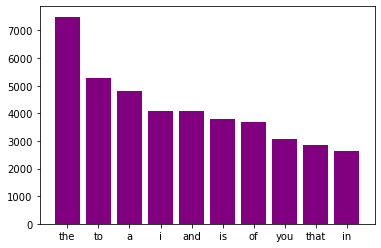

In [ ]:
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y,color='purple')    

plot_top_stopwords_barchart(pdf['cleaned_text'])

**<span style='color:red '>Remove stopwords</span>**

In [ ]:
stops = set(stopwords.words('english'))
def remove_stop_words(sample, cores = 2):
    sample = sample.lower()
    sample = [word for word in sample.split() if not word in stops]
    sample = ' '.join(sample)
    
    return sample
pdf['stop_removed']=pdf['cleaned_text'].apply(lambda x: remove_stop_words(x))      
pdf.head(2)

,cleaned_text,oh_label,stop_removed
0,i read them in change in meaning the history o...,0.0,read change meaning history slavery
1,now you claim that people who tried to stop hi...,0.0,claim people tried stop becoming terrorist mad...


**<span style='color:red '>Lemmatize the words</span>**

In [7]:
lemmatizer = WordNetLemmatizer()
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
def get_wordnet_pos(word):
    
    treebank_tag = nltk.pos_tag([word])[0][1]
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemma_clean_text(sample):
    sample = sample.split()
    sample = [lemmatizer.lemmatize(word.lower(), get_wordnet_pos(word.lower())) for word in sample]
    sample = ''.join(sample) 
    return sample

pdf['lemma']=pdf['stop_removed'].apply(lambda x: lemma_clean_text(x))   
pdf.head(3)  

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


**<span style='color:red '>Spell check the words</span>**

In [ ]:
def spellCheck(sample):
     sample = str(TextBlob(sample).correct())
     return sample
pdf['spell']=pdf['lemma'].apply(lambda x: spellCheck(x))   
pdf.head(3)        

,cleaned_text,oh_label,stop_removed,lemma,spell
0,i read them in change in meaning the history o...,0.0,read change meaning history slavery,read change meaning history slavery,read change meaning history slavery
1,now you claim that people who tried to stop hi...,0.0,claim people tried stop becoming terrorist mad...,claim people tried stop becoming terrorist mad...,claim people tried stop becoming terrorist mad...
2,call me but when i go to an auto place i would...,1.0,call go auto place would rather talk guy,call go auto place would rather talk guy,call go auto place would rather talk guy


In [ ]:
pdf.to_csv('spell_checked.csv',index=False)

 **<span style='color:red '>Feature Extraction and EDA</span>**

In [ ]:
pdf.spell.isna().sum()

786

In [ ]:
pdf.dropna(inplace=True)

 **<span style='color:red '>Most frequent word</span>**

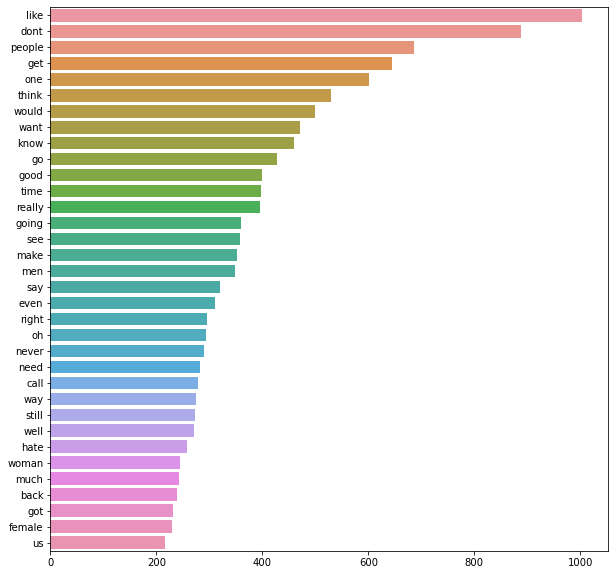

In [ ]:
def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    figure, ax = plt.subplots(figsize=(10, 10))        
    sns.barplot(x=y,y=x,ax=ax)
    #p.figure.set_dpi(200)
    
plot_top_non_stopwords_barchart(pdf['spell'])    

 **<span style='color:red '>Bigram words</span>**

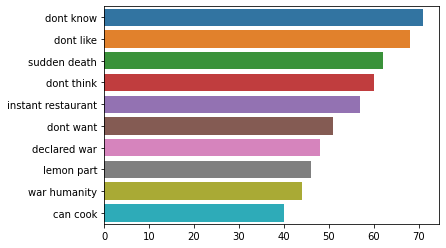

In [ ]:
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

plot_top_ngrams_barchart(pdf['spell'],2)    

 **<span style='color:red '>Trigram words</span>**

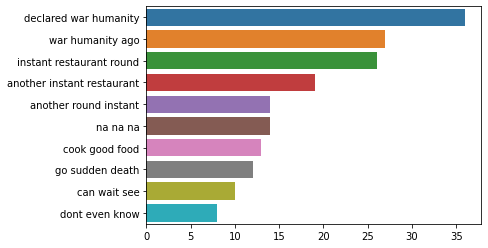

In [ ]:
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)
plot_top_ngrams_barchart(pdf['spell'],3)        

In [ ]:
pdf['spell'][0]

'read change meaning history slavery'


 **<span style='color:red '>Topic modeling exploration with pyLDAvis</span>**

 * Topic modeling is the process of using unsupervised learning techniques to extract the main topics that occur in a collection of documents.

In [ ]:
from nltk.tokenize import word_tokenize
def get_lda_objects(text):
    nltk.download('stopwords')    
    stop=set(stopwords.words('english'))

    
    def _preprocess_text(text):
        corpus=[]
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)

        return corpus
    corpus=_preprocess_text(text)  
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 2, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
    return vis

lda_model, bow_corpus, dic = get_lda_objects(pdf['spell'])    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mohamed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
lda_model.show_topics()

[(0,
  '0.019*"dont" + 0.012*"get" + 0.010*"know" + 0.009*"people" + 0.009*"like" + 0.008*"need" + 0.008*"really" + 0.007*"men" + 0.006*"want" + 0.006*"never"'),
 (1,
  '0.013*"like" + 0.012*"one" + 0.011*"time" + 0.007*"still" + 0.007*"think" + 0.007*"people" + 0.006*"way" + 0.006*"right" + 0.005*"ever" + 0.005*"back"')]

In [ ]:

plot_lda_vis(lda_model, bow_corpus, dic)

PreparedData(topic_coordinates=             x    y  topics  cluster     Freq
topic                                        
0      0.16018  0.0       1        1  51.3866
1     -0.16018  0.0       2        1  48.6134, topic_info=       Term        Freq       Total Category  logprob  loglift
44     dont  801.000000  801.000000  Default  30.0000  30.0000
133     get  517.000000  517.000000  Default  29.0000  29.0000
67     know  426.000000  426.000000  Default  28.0000  28.0000
117    time  426.000000  426.000000  Default  27.0000  27.0000
380    need  352.000000  352.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
187    even  145.336193  294.516223   Topic2  -5.6031   0.0150
205    want  154.634923  421.635734   Topic2  -5.5410  -0.2818
512  pretty  123.641709  174.603255   Topic2  -5.7647   0.3761
101     say  133.374446  268.257886   Topic2  -5.6889   0.0225
597    well  130.344255  281.195203   Topic2  -5.7119  -0.0476

[147 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
724       1  0.996579   able
724       2  0.015819   able
476       1  0.996497  abuse
476       2  0.010273  abuse
576       1  0.985721    ago
...     ...       ...    ...
867       2  0.988443   word
84        1  0.531942  would
84        2  0.467912  would
206       1  0.994130    yes
206       2  0.005780    yes

[207 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

**On the left side, the area of each circle represents the importance of the topic relative to the corpus. As there are two topics, we have two circles.**

**The distance between the center of the circles indicates the similarity between the topics. Both the topics are distinct due to distance.**


**On the right side, the histogram of each topic shows the top 30 relevant words.** 

Topic 1: 'dont','get','know','people','like','need','really','men','want'

Topic 2: 'like','one','time','still', 'think', 'people', 'way','right'

**<span style='color:red '>Word count </span>**

**<span style='color:red '>Plot of number of words in each sentence</span>**

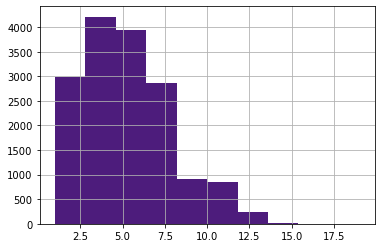

In [ ]:
def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).\
        hist(color='#4d1c7c' )
plot_word_number_histogram(pdf['spell'])     

In [ ]:
pdf['word_count'] = pdf.iloc[:,-1].apply(lambda x: len(str(x).split(" ")))
pdf.head(3)

,cleaned_text,oh_label,stop_removed,lemma,spell,word_count
0,i read them in change in meaning the history o...,0.0,read change meaning history slavery,read change meaning history slavery,read change meaning history slavery,5
1,now you claim that people who tried to stop hi...,0.0,claim people tried stop becoming terrorist mad...,claim people tried stop becoming terrorist mad...,claim people tried stop becoming terrorist mad...,10
2,call me but when i go to an auto place id rath...,1.0,call go auto place id rather talk guy,call go auto place id rather talk guy,call go auto place id rather talk guy,8


<AxesSubplot:>

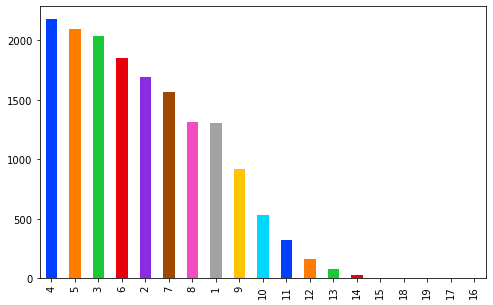

In [ ]:
plt.figure(figsize=(8,5))
pdf['word_count'].value_counts().plot(kind='bar', color=sns.color_palette('bright'))

**<span style='color:red '>Char count </span>**

**<span style='color:red '> Plot of sentence length</span>**


<AxesSubplot:>

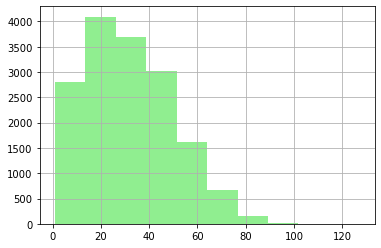

In [ ]:
pdf['spell'].str.len().hist(color='lightgreen')

In [ ]:
pdf['char_count'] = pdf['spell'].str.len() ## this also includes spaces
pdf[['spell','char_count']]

,spell,char_count
0,read change meaning history slavery,35
1,claim people tried stop becoming terrorist mad...,68
2,call go auto place id rather talk guy,37
3,wrong example exactly,21
5,preacher tortured five daughter death,37
...,...,...
16843,feeling sorry safe at going home,32
16844,pretty good happy well never eating place,41
16845,lemon please go one season without someone cal...,60
16846,stupid talk blocked,19


<AxesSubplot:>

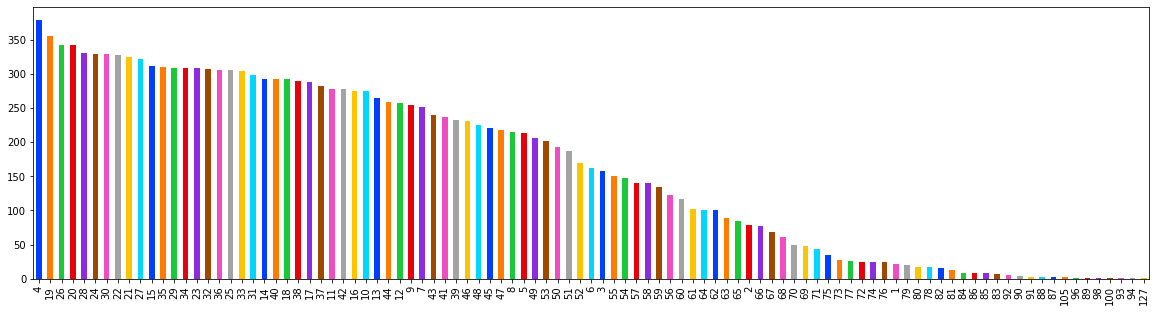

In [ ]:
plt.figure(figsize=(20,5))
pdf['char_count'].value_counts().plot(kind='bar', color=sns.color_palette('bright'))

 **<span style='color:red '>Average word count</span>**

In [ ]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/(len(words)+0.000001))

pdf['avg_word'] = pdf['spell'].apply(lambda x: avg_word(x)).round(1)
pdf[['spell','avg_word']].head()

,spell,avg_word
0,read change meaning history slavery,6.2
1,claim people tried stop becoming terrorist mad...,5.9
2,call go auto place id rather talk guy,3.7
3,wrong example exactly,6.3
5,preacher tortured five daughter death,6.6


<AxesSubplot:>

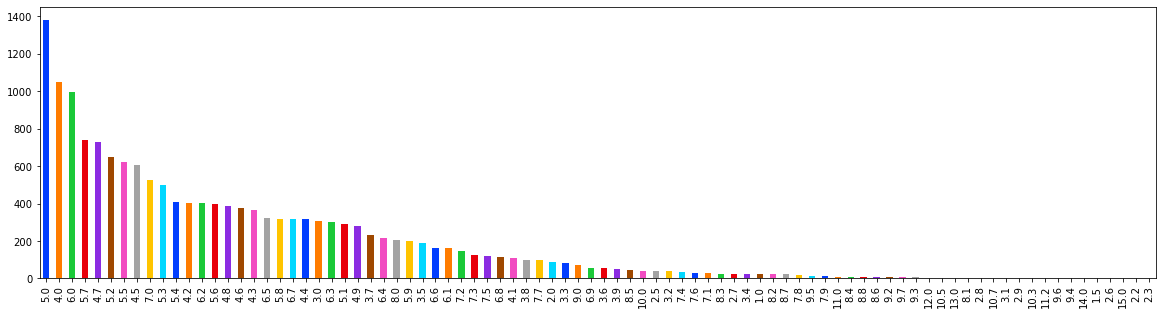

In [ ]:
plt.figure(figsize=(20,5))
pdf['avg_word'].value_counts().plot(kind='bar', color=sns.color_palette('bright'))

**Removing records with zero words** 

In [ ]:
pdf= pdf[~(pdf['char_count'] == 0)].reset_index(drop=True)

In [ ]:
pdf[['spell','word_count','char_count','avg_word','oh_label']][:5]

,spell,word_count,char_count,avg_word,oh_label
0,read change meaning history slavery,5,35,6.2,0.0
1,claim people tried stop becoming terrorist mad...,10,68,5.9,0.0
2,call go auto place id rather talk guy,8,37,3.7,1.0
3,wrong example exactly,3,21,6.3,1.0
4,preacher tortured five daughter death,5,37,6.6,0.0


## **<span style='color:red '>Word Cloud</span>**

### Non Toxic - Word Cloud

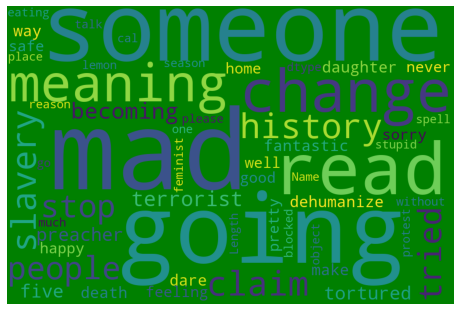

In [ ]:
from wordcloud import ImageColorGenerator
g = str(pdf[pdf['oh_label']==0]['spell'])

wordcloud = WordCloud(width = 900, height = 600, background_color ='green',min_font_size = 10).generate(g)
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.show()

### Toxic - Word Cloud

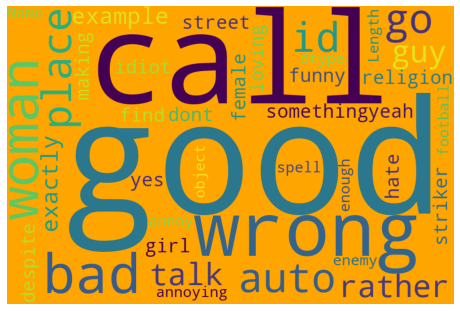

In [ ]:
from wordcloud import ImageColorGenerator
g = str(pdf[pdf['oh_label']==1]['spell'])

wordcloud = WordCloud(width = 900, height = 600, background_color ='orange',min_font_size = 10).generate(g)
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.show()

In [ ]:
tdf=pdf.iloc[:,[-1,1]]
tdf.rename(columns={'spell':'text'},inplace=True)
tdf.head(5)

,text,oh_label
0,read change meaning history slavery,0.0
1,claim people tried stop becoming terrorist mad...,0.0
2,call go auto place would rather talk guy,1.0
3,wrong example exactly,1.0
4,,0.0


In [ ]:
tdf.oh_label.value_counts()

0.0    11501
1.0     5347
Name: oh_label, dtype: int64

In [ ]:
tdf.to_csv("tdf.csv",index=False)

In [ ]:
tdf=pd.read_csv("dataset/tdf.csv")


## **<span style='color:blue '>Word Embeddings</span>**

In [ ]:
tdf.shape

(16062, 2)

In [ ]:
X =tdf.iloc[:,0]
y=tdf['oh_label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=101,stratify=y)

In [ ]:
y_train.value_counts()

0.0    7562
1.0    3681
Name: oh_label, dtype: int64

### **<span style='color:red '>Build Vocabulary </span>**

In [23]:
# load doc and add to vocab
def build_vocab(vocab_obj, text):
    sample = text
    tokens = [word for word in sample.split()]
    vocab_obj.update(tokens)
  

In [ ]:
vocab = Counter()
for text in tdf['text']:
    build_vocab(vocab, text)  

In [ ]:
print(vocab.most_common(50))

[('at', 1015), ('like', 1003), ('dont', 889), ('people', 687), ('get', 645), ('one', 602), ('think', 530), ('would', 499), ('want', 471), ('know', 459), ('can', 457), ('go', 427), ('good', 399), ('time', 398), ('really', 395), ('going', 360), ('see', 358), ('make', 353), ('men', 349), ('say', 320), ('even', 311), ('that', 296), ('right', 295), ('oh', 294), ('never', 290), ('need', 283), ('call', 279), ('way', 274), ('still', 272), ('well', 270), ('hate', 258), ('there', 256), ('woman', 244), ('much', 243), ('back', 239), ('got', 231), ('female', 230), ('doesn', 223), ('us', 217), ('didn', 215), ('ever', 215), ('love', 215), ('stop', 211), ('every', 208), ('look', 207), ('many', 207), ('thing', 206), ('hope', 206), ('someone', 204), ('twitter', 201)]


#**<span style='color:red '>Model Building </span>**

##<b> Approach <b>
<b>A.Given twitter parsed imbalanced dataset <b>

 *  1.Integer encoding + Neural networks
 *  2.Glove Embedding  + LSTM Neural networks
 *  3.Glove Embedding + SVM  


 <b>B.Given Twitter parsed dataset would be downsampled to a balanced dataset <b>
 * 1.Glove Embedding  + LSTM
 * 2.Glove Embedding + GRU

<b>C.Combined twitter parsed dataset with additional data taken from toxicity parsed dataset <b>  
 * 1.Bidirectional LSTM
 * 2.Integer encoding + Neural networks

##<b>A.Given twitter parsed imbalanced dataset <b>

 *  1.Integer encoding + Neural networks

In [21]:
def create_tokenizer(lines):
    #Tokenization is a method to segregate a particular text into small chunks or tokens.
    tokenizer = Tokenizer()
    #The fit_on_texts method is a part of Keras tokenizer class which is used to update the internal vocabulary for the texts list.
    #We need to call before using other methods of texts_to_sequences or texts_to_matrix.
    tokenizer.fit_on_texts(lines)
    return tokenizer


In [ ]:
#The document_count prints the number of documents present in our corpus
token = create_tokenizer(X_train)
token.document_count

11243

In [ ]:
#Finding the size of the vocalulary which would be sent as param to keras model building.
vocab_size = len(token.word_index) + 1
#Max_length of the sentence in X_train is required to be sent as param to padding.
max_length = max([len(s.split()) for s in X_train])
print('The size of the vocabulary :',vocab_size)
print('The maximum length of the sentence in X_train :',max_length )

The size of the vocabulary : 6035
The maximum length of the sentence in X_train : 17


In [22]:
def encode_docs(tokenizer, max_length, docs):
    # texts_to_sequences method helps in converting tokens of text corpus into a sequence of integers.
    encoded = tokenizer.texts_to_sequences(docs)
    #encoded_tf= tokenizer.sequences_to_matrix(docs, mode='tfidf')
    # pad sequences
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded
 

In [ ]:
x_train = encode_docs(token, max_length, X_train)
x_test = encode_docs(token, max_length, X_test)   

<b> Integer Encoding + Neural Networks <b>

In [ ]:
# define the model
def define_model(vocab_size, max_length, n_words):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_length))
    model.add(Flatten(input_shape=(n_words,)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
clf_model = define_model(vocab_size, max_length, x_train.shape[1])    
clf_model.fit(x_train, y_train.values,validation_split=0.2, epochs=10, verbose=2, batch_size=256)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 8994 samples, validate on 2249 samples
Epoch 1/10
8994/8994 - 1s - loss: 0.6365 - acc: 0.6631 - val_loss: 0.6126 - val_acc: 0.6750 - 1s/epoch - 134us/sample
Epoch 2/10
8994/8994 - 1s - loss: 0.5479 - acc: 0.7103 - val_loss: 0.5454 - val_acc: 0.7470 - 921ms/epoch - 102us/sample
Epoch 3/10
8994/8994 - 1s - loss: 0.3337 - acc: 0.8672 - val_loss: 0.6268 - val_acc: 0.7248 - 861ms/epoch - 96us/sample
Epoch 4/10
8994/8994 - 1s - loss: 0.1883 - acc: 0.9281 - val_loss: 0.7288 - val_acc: 0.7065 - 787ms/epoch - 87us/sample
Epoch 5/10
8994/8994 - 1s - loss: 0.1248 - acc: 0.9575 - val_loss: 0.8839 - val_acc: 0.7056 - 897ms/epoch - 100us/sample
Epoch 6/10
8994/8994 - 1s - loss: 0.0843 - acc: 0.9723 - val_loss: 1.0743 - val_acc: 0.7074 - 869ms/epoch - 97us/sample
Epoch 7/10
8994/8994 - 1s - loss: 0.0662 - acc: 0.9781 - val_loss: 1.1307 - val_acc: 0.7105 - 855ms/epoch - 95us/s

In [ ]:
def decode_sentiment(score):

    return 1 if score > 0.5 else 0

scores = clf_model.predict(x_test, verbose = 1, batch_size = 256)
y_pred_1d = [decode_sentiment(score) for score in scores]
print(classification_report(list(y_test), y_pred_1d))

              precision    recall  f1-score   support

         0.0       0.76      0.80      0.78      3241
         1.0       0.54      0.48      0.51      1578

    accuracy                           0.69      4819
   macro avg       0.65      0.64      0.64      4819
weighted avg       0.69      0.69      0.69      4819



<b> Observation <b>

The weighted F1 score is 68%

<b> 2.LSTM based Neural Networks with Glove embedding <b>

<b> In an embedding, words are represented by dense vectors where a vector

 represents the projection of the word into a continuous vector space.

The position of a word in the learned vector space is referred to as its embedding.<b>

In [ ]:
f = open('dataset/glove.42B.300d.txt', encoding='utf-8')


In [ ]:
def read_glove_vector(f):
    words = set()
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
    return word_to_vec_map

word_to_vec_map = read_glove_vector(f)



In [ ]:
embed_vector_len = word_to_vec_map['moon'].shape[0]
def emb_mat(token):
    emb_matrix = np.zeros((vocab_size, embed_vector_len ))

    for word, index in token.word_index.items():
      embedding_vector = word_to_vec_map.get(word)
      if embedding_vector is not None:
        emb_matrix[index, :] = embedding_vector
  
    return emb_matrix


In [ ]:

def createModel(input_shape):
 
  X_indices = Input(input_shape)

  embeddings = embedding_layer(X_indices)
  X = LSTM(128, return_sequences=True)(embeddings)

  X = Dropout(0.6)(X)

  X = LSTM(128)(X)

  X = Dense(1, activation='sigmoid')(X)

  model = Model(inputs=X_indices, outputs=X)

  return model

In [ ]:
emb_matrix=emb_mat(token)
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embed_vector_len , input_length=max_length, weights = [emb_matrix], trainable=False)
lstm_model = createModel((max_length,))
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)
lstm_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

lstm_model.fit(x_train, y_train, batch_size=64, epochs=15,verbose=2,validation_split=0.2)
lstm_model.evaluate(x_test, y_test, verbose=0)  


Epoch 1/15
141/141 - 28s - loss: 0.6212 - get_f1: 0.1533 - accuracy: 0.6883 - val_loss: 0.5490 - val_get_f1: 0.4868 - val_accuracy: 0.7377 - 28s/epoch - 199ms/step
Epoch 2/15
141/141 - 14s - loss: 0.5438 - get_f1: 0.5047 - accuracy: 0.7402 - val_loss: 0.5277 - val_get_f1: 0.5247 - val_accuracy: 0.7488 - 14s/epoch - 101ms/step
Epoch 3/15
141/141 - 17s - loss: 0.5278 - get_f1: 0.5263 - accuracy: 0.7498 - val_loss: 0.5204 - val_get_f1: 0.5250 - val_accuracy: 0.7519 - 17s/epoch - 119ms/step
Epoch 4/15
141/141 - 23s - loss: 0.5141 - get_f1: 0.5532 - accuracy: 0.7591 - val_loss: 0.5167 - val_get_f1: 0.5389 - val_accuracy: 0.7546 - 23s/epoch - 161ms/step
Epoch 5/15
141/141 - 16s - loss: 0.5042 - get_f1: 0.5622 - accuracy: 0.7655 - val_loss: 0.5171 - val_get_f1: 0.5560 - val_accuracy: 0.7532 - 16s/epoch - 114ms/step
Epoch 6/15
141/141 - 15s - loss: 0.4974 - get_f1: 0.5704 - accuracy: 0.7694 - val_loss: 0.5139 - val_get_f1: 0.5562 - val_accuracy: 0.7603 - 15s/epoch - 108ms/step
Epoch 7/15
141/1

[0.5480144619941711, 0.5498398542404175, 0.7470429539680481]

In [ ]:
def decode_sentiment(score):

    return 1 if score > 0.5 else 0

scores = lstm_model.predict(x_test, verbose = 1, batch_size = 256)
y_pred_1d = [decode_sentiment(score) for score in scores]
print(classification_report(list(y_test), y_pred_1d))

19/19 [==============================] - 3s 91ms/step
              precision    recall  f1-score   support

         0.0       0.78      0.87      0.82      3241
         1.0       0.65      0.50      0.57      1578

    accuracy                           0.75      4819
   macro avg       0.71      0.68      0.69      4819
weighted avg       0.74      0.75      0.74      4819



<b> Observation: The weighted F1score is 74% <b>

<b> 3.Glove Embedding + SVM <b>

In [ ]:
def prepare_sequence(ds, word_to_vec_map):
    #input: Series, and word_to_vec_map of size(vocab_size,200)
    #output: returns shape of (len(ds), 200)
    traintest_X = []
    for sentence in tqdm(ds):
        sequence_words = np.zeros((word_to_vec_map['cucumber'].shape))
        for word in sentence.split():
            if word in word_to_vec_map.keys():
                temp_X = word_to_vec_map[word]
            else:
                temp_X = word_to_vec_map['#']
            #print(temp_X)
            sequence_words+=(temp_X)/len(sentence)
            #print(sequence_words)
        traintest_X.append(sequence_words)
    return np.array(traintest_X)

In [ ]:
#concatenate all sequences for training and testing set
train_w2v = prepare_sequence(X_train, word_to_vec_map)
valid_w2v = prepare_sequence(X_test, word_to_vec_map)

100%|██████████| 4819/4819 [00:00<00:00, 21908.34it/s]


In [ ]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid,y_test, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, y_test),metrics.f1_score(predictions, y_test)

In [ ]:

accuracy ,f1= train_model(svm.SVC(), train_w2v, y_train, valid_w2v,y_test)
print("SVM accuracy", accuracy)
print("SVM f1 ", f1)

SVM accuracy 0.7443452998547416
SVM f1  0.47574468085106386


<b> Original imbalanced dataset <b>

S.No------Model--------------------------------------------F1_score
1.        Glove+LSTM-------------------------------------------0.74 
2.        integer Encoding +Neural networks-----------------0.69
3.        Glove+SVM--------------------------------------------0.48

##<b>B.Attempting with balanced dataset by undersampling technique<b>

In [ ]:
df_i=tdf[tdf['oh_label']==0.0].sample(frac=0.5)
df_i.shape

(5402, 2)

In [ ]:
bdf=df_i.append(tdf.loc[tdf['oh_label']==1.0])
bdf=bdf.sample(frac=1)
bdf['oh_label'].value_counts()

0.0    5402
1.0    5259
Name: oh_label, dtype: int64

In [ ]:
X =bdf.iloc[:,0]
y=bdf['oh_label']

<b> LSTM model + Glove Embedding<b>

In [ ]:
bX_train, bX_test, by_train, by_test = train_test_split(X,y, test_size=0.3, random_state=101)

In [ ]:
token = create_tokenizer(bX_train)
#Finding the size of the vocalulary which would be sent as param to keras model building.
vocab_size = len(token.word_index) + 1
#Max_length of the sentence in X_train is required to be sent as param to padding.
max_length = max([len(s.split()) for s in bX_train])
print('The size of the vocabulary :',vocab_size)
print('The maximum length of the sentence in X_train :',max_length )

bx_train = encode_docs(token, max_length, bX_train)
bx_test = encode_docs(token, max_length, bX_test)   

The size of the vocabulary : 5147
The maximum length of the sentence in X_train : 19


In [ ]:
emb_matrix=emb_mat(token)
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embed_vector_len , input_length=max_length, weights = [emb_matrix], trainable=False)
lstm_model = createModel((max_length,))
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)
lstm_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(bx_train, by_train, batch_size=64, epochs=15,verbose=2,validation_split=0.2)

Epoch 1/15
94/94 - 14s - loss: 0.6777 - accuracy: 0.5962 - val_loss: 0.6218 - val_accuracy: 0.6551 - 14s/epoch - 153ms/step
Epoch 2/15
94/94 - 10s - loss: 0.6104 - accuracy: 0.6725 - val_loss: 0.5885 - val_accuracy: 0.6852 - 10s/epoch - 104ms/step
Epoch 3/15
94/94 - 10s - loss: 0.5864 - accuracy: 0.6929 - val_loss: 0.5850 - val_accuracy: 0.6885 - 10s/epoch - 105ms/step
Epoch 4/15
94/94 - 11s - loss: 0.5727 - accuracy: 0.7033 - val_loss: 0.5743 - val_accuracy: 0.6952 - 11s/epoch - 112ms/step
Epoch 5/15
94/94 - 11s - loss: 0.5613 - accuracy: 0.7122 - val_loss: 0.5691 - val_accuracy: 0.6966 - 11s/epoch - 115ms/step
Epoch 6/15
94/94 - 10s - loss: 0.5525 - accuracy: 0.7204 - val_loss: 0.5695 - val_accuracy: 0.6986 - 10s/epoch - 104ms/step
Epoch 7/15
94/94 - 10s - loss: 0.5427 - accuracy: 0.7247 - val_loss: 0.5662 - val_accuracy: 0.7026 - 10s/epoch - 105ms/step
Epoch 8/15
94/94 - 10s - loss: 0.5341 - accuracy: 0.7308 - val_loss: 0.5766 - val_accuracy: 0.6986 - 10s/epoch - 105ms/step
Epoch 9/

In [ ]:
def decode_sentiment(score):

    return 1 if score > 0.5 else 0

scores = lstm_model.predict(bx_test, verbose = 1, batch_size = 256)
y_pred_1d = [decode_sentiment(score) for score in scores]
print(classification_report(list(by_test), y_pred_1d))

13/13 [==============================] - 2s 168ms/step
              precision    recall  f1-score   support

         0.0       0.68      0.72      0.70      1623
         1.0       0.70      0.66      0.68      1576

    accuracy                           0.69      3199
   macro avg       0.69      0.69      0.69      3199
weighted avg       0.69      0.69      0.69      3199



<b> Observation <b>

LSTM weighted F1 score decreased to 69%(balanced dataset)  from 74% (imbalanced dataset) 

<b> 2. GRU +GLOVE Embedding <b>

In [ ]:
embed_vector_len = word_to_vec_map['moon'].shape[0]

emb_matrix = np.zeros((vocab_size, embed_vector_len ))

for word, index in token.word_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    emb_matrix[index, :] = embedding_vector

emb_dim = emb_matrix.shape[1]
gru_model = Sequential()
gru_model.add(Embedding(vocab_size, emb_dim, trainable = False, weights=[emb_matrix]))
gru_model.add(GRU(128, return_sequences=False))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(1, activation = 'sigmoid'))
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
batch_size = 64
epochs  = 15
history = gru_model.fit(bx_train, np.asarray(by_train), validation_split=0.2, batch_size = batch_size, epochs = epochs)

Epoch 1/15
94/94 [==============================] - 7s 52ms/step - loss: 0.6482 - accuracy: 0.6080 - val_loss: 0.5799 - val_accuracy: 0.6959
Epoch 2/15
94/94 [==============================] - 4s 46ms/step - loss: 0.5889 - accuracy: 0.6941 - val_loss: 0.5705 - val_accuracy: 0.7060
Epoch 3/15
94/94 [==============================] - 4s 47ms/step - loss: 0.5631 - accuracy: 0.7113 - val_loss: 0.5640 - val_accuracy: 0.7006
Epoch 4/15
94/94 [==============================] - 4s 46ms/step - loss: 0.5368 - accuracy: 0.7298 - val_loss: 0.5581 - val_accuracy: 0.7106
Epoch 5/15
94/94 [==============================] - 4s 46ms/step - loss: 0.5060 - accuracy: 0.7542 - val_loss: 0.5809 - val_accuracy: 0.7106
Epoch 6/15
94/94 [==============================] - 4s 46ms/step - loss: 0.4761 - accuracy: 0.7695 - val_loss: 0.5777 - val_accuracy: 0.7100
Epoch 7/15
94/94 [==============================] - 4s 47ms/step - loss: 0.4368 - accuracy: 0.7993 - val_loss: 0.6337 - val_accuracy: 0.6604
Epoch 8/15
94

In [ ]:
def decode_sentiment(score):

    return 1 if score > 0.5 else 0

scores = gru_model.predict(bx_test, verbose = 1, batch_size = 256)
y_pred_1d = [decode_sentiment(score) for score in scores]
print(classification_report(list(by_test), y_pred_1d))

13/13 [==============================] - 2s 74ms/step
              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68      1623
         1.0       0.67      0.67      0.67      1576

    accuracy                           0.68      3199
   macro avg       0.68      0.68      0.68      3199
weighted avg       0.68      0.68      0.68      3199



<b> Original balanced dataset <b>

S.No------Model-----------------F1_score

1.--------Glove+LSTM------------69%

2.--------Glove+GRU-------------68%



##<b>C.Collecting additional toxic data from toxicity_parsed dataset <b>

In [ ]:
tox_df=pd.read_csv(r"C:\Users\Mohamed\Desktop\MGP\NLP\dataset\toxicity_parsed_dataset.csv")

In [ ]:
tox_df.drop(columns=['ed_label_0','ed_label_1'],axis=1,inplace=True)

In [ ]:
toxone_df = tox_df[tox_df['oh_label']==1].sample(frac=0.55)
toxone_df.oh_label.value_counts()

In [ ]:
toxone_df.columns = map(str.lower, toxone_df.columns)

Preprocessing the text data

In [ ]:
toxone_df['lowerCase'] = toxone_df['text'].apply(lambda x: lowerCase(x))
toxone_df['urls_removed'] = toxone_df['lowerCase'].apply(lambda x: remove_url(x))
toxone_df['htmltag_removed'] = toxone_df['urls_removed'].apply(lambda x: remove_html(x))
toxone_df['square_parathensis_removed'] = toxone_df['htmltag_removed'].apply(lambda x: remove_sqr(x))
toxone_df['contraction_fixed'] = toxone_df['square_parathensis_removed'].apply(lambda x: contract(x))
toxone_df['punc_removed'] = toxone_df['contraction_fixed'].apply(lambda x: remove_punctuations(x))
toxone_df['nonEnglish_removed'] = toxone_df['punc_removed'].apply(lambda x: remove_special_characters(x))
toxone_df['hashtag_removed'] =toxone_df['nonEnglish_removed'].apply(lambda x: remove_hashtags_only(x))
toxone_df['emoji_removed'] = toxone_df['hashtag_removed'].apply(lambda x: remove_emojis(x))
toxone_df['digitText_removed'] = toxone_df['emoji_removed'].apply(lambda x: remove_digitsText(x))
toxone_df['stop_removed']=toxone_df['digitText_removed'].apply(lambda x: remove_stop_words(x))      
toxone_df['lemma']=toxone_df['stop_removed'].apply(lambda x: lemma_clean_text(x))   
toxone_df['spell']=toxone_df['lemma'].apply(lambda x: spellCheck(x))   
toxone_df['char_count'] = toxone_df['spell'].str.len() ## this also includes spaces
toxone_df= toxone_df[~(toxone_df['char_count'] == 0)].reset_index(drop=True)



In [ ]:
toxone_df.isna().sum()

In [ ]:
ptox_df=toxone_df[['spell','oh_label']]
ptox_df.rename(columns={'spell':'text'},inplace=True)

In [ ]:
sdf = tdf.append(ptox_df)
sdf = sdf.sample(frac=1)
sdf.shape

In [38]:
sdf.oh_label.value_counts()

1.0    13499
0.0    10781
Name: oh_label, dtype: int64

In [13]:
#Remove data with missing values
sdf.isna().sum()
sdf.dropna(inplace=True)

In [14]:
#Removing duplicate entries in each sentence.
def remove_dup(sample):
    word_dic = Counter(sample.split())
    result = " ".join(word_dic.keys())
    return result
sdf['textdup_removed'] = sdf['text'].apply(lambda x: remove_dup(x))


In [ ]:
sdf.head(3)

,text,oh_label,textdup_removed
0,toll claim,0.0,toll claim
2,edit page top class saw nan,1.0,edit page top class saw nan
3,going lot hungry going breakfast,0.0,going lot hungry breakfast


<b> Modeling <b>

In [15]:
X =sdf.iloc[:,2]
y=sdf['oh_label']

In [19]:
sX_train, sX_test, sy_train, sy_test = train_test_split(X,y, test_size=0.1, random_state=101)

In [24]:
vocab = Counter()
for text in sdf['textdup_removed']:
    build_vocab(vocab, text) 

In [17]:
def save__vocab_list(vocab, filename):
    lines = [a for a in vocab.keys()]
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w', encoding="utf-8")
    # write text
    file.write(data)
    # close file
    file.close()
save__vocab_list(vocab, 'vocab.txt')    

In [25]:
token = create_tokenizer(sX_train)
#Finding the size of the vocalulary which would be sent as param to keras model building.
vocab_size = len(token.word_index) + 1
#Max_length of the sentence in X_train is required to be sent as param to padding.
max_length = max([len(s.split()) for s in sX_train])
print('The size of the vocabulary :',vocab_size)
print('The maximum length of the sentence in X_train :',max_length )

sx_train = encode_docs(token, max_length, sX_train)
sx_test = encode_docs(token, max_length, sX_test) 

The size of the vocabulary : 9448
The maximum length of the sentence in X_train : 262


In [19]:
import pickle

# saving
with open('token.pickle', 'wb') as handle:
    pickle.dump(token, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('token.pickle', 'rb') as handle:
    token = pickle.load(handle)

<b> 1.BERT +Glove embedding (combined - Toxicity parsed + twitter parsed dataset) <b>

In [ ]:
emb_matrix=emb_mat(token)
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embed_vector_len , input_length=max_length, weights = [emb_matrix], trainable=False)
sequence_input = Input(shape = (max_length,), dtype = 'int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.0)(embedding_sequences)
x = Conv1D(64, 5, activation = 'relu')(x)
x = Bidirectional(LSTM(64, dropout = 0.2, recurrent_dropout = 0.2))(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

LR = 1e-3

model.compile(optimizer = Adam(learning_rate = LR), loss = 'binary_crossentropy', metrics = ['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor = 0.1, min_lr = 0.01, monitor = 'val_loss', verbose = 1)

In [ ]:
history = model.fit(sx_train, sy_train, batch_size = 256, epochs = 10, validation_data = (sx_test, sy_test), callbacks = [ReduceLROnPlateau])

Epoch 1/10
86/86 [==============================] - 279s 3s/step - loss: 0.4484 - accuracy: 0.7780 - val_loss: 0.4669 - val_accuracy: 0.7661 - lr: 0.0010
Epoch 2/10
86/86 [==============================] - 262s 3s/step - loss: 0.3859 - accuracy: 0.8188 - val_loss: 0.4844 - val_accuracy: 0.7669 - lr: 0.0010
Epoch 3/10
86/86 [==============================] - 255s 3s/step - loss: 0.3316 - accuracy: 0.8502 - val_loss: 0.5221 - val_accuracy: 0.7574 - lr: 0.0010
Epoch 4/10
86/86 [==============================] - 237s 3s/step - loss: 0.2787 - accuracy: 0.8790 - val_loss: 0.5478 - val_accuracy: 0.7661 - lr: 0.0010
Epoch 5/10
86/86 [==============================] - 238s 3s/step - loss: 0.2379 - accuracy: 0.8985 - val_loss: 0.5779 - val_accuracy: 0.7624 - lr: 0.0010
Epoch 6/10
86/86 [==============================] - 237s 3s/step - loss: 0.2045 - accuracy: 0.9146 - val_loss: 0.7081 - val_accuracy: 0.7714 - lr: 0.0010
Epoch 7/10
86/86 [==============================] - 238s 3s/step - loss: 0.1

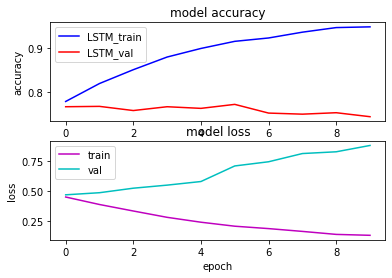

In [ ]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c = 'b')
at.plot(history.history['val_accuracy'], c ='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc ='upper left')

al.plot(history.history['loss'], c ='m')
al.plot(history.history['val_loss'], c ='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [ ]:
def decode_sentiment(score):

    return 1 if score > 0.5 else 0

scores = model.predict(sx_test, verbose = 1, batch_size = 10000)
y_pred_1d = [decode_sentiment(score) for score in scores]
print(classification_report(list(sy_test), y_pred_1d))

1/1 [==============================] - 5s 5s/step
              precision    recall  f1-score   support

         0.0       0.76      0.63      0.69      1094
         1.0       0.73      0.84      0.78      1334

    accuracy                           0.74      2428
   macro avg       0.75      0.73      0.73      2428
weighted avg       0.75      0.74      0.74      2428



<b> 2.Interger encoding + neural networks with combined dataset of twitter + toxcicity dataset<b>

In [17]:
# define the model
def define_model(vocab_size, max_length, n_words):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_length))
    model.add(Flatten(input_shape=(n_words,)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
clf_model = define_model(vocab_size, max_length, sx_train.shape[1])    
clf_model.fit(sx_train, sy_train.values,validation_split=0.2, epochs=10, verbose=2, batch_size=256)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 17481 samples, validate on 4371 samples
Epoch 1/10
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
17481/17481 - 10s - loss: 0.6399 - acc: 0.5965 - val_loss: 0.5126 - val_acc: 0.7390
Epoch 2/10
17481/17481 - 10s - loss: 0.4347 - acc: 0.7906 - val_loss: 0.4860 - val_acc: 0.7593
Epoch 3/10
17481/17481 - 10s - loss: 0.3148 - acc: 0.8657 - val_loss: 0.5443 - val_acc: 0.7467
Epoch 4/10
17481/17481 - 10s - loss: 0.2140 - acc: 0.9177 - val_loss: 0.6468 - val_acc: 0.7369
Epoch 5/10
17481/17481 - 10s - loss: 0.1566 - acc: 0.9410 - val_loss: 0.7997 - val_acc: 0.7316
Epoch 6/10
17481/17481 - 10s - loss: 0.1263 - acc: 0.9527 - val_loss: 0.8535 - val_acc: 0.7241
Epoch 7/10
17481/17481 - 10s - loss: 0.1067 - acc: 0.9600 - val_loss: 0.8741 - val_acc: 0.7202
Epoch 8/10
17481/17481 - 10s - loss: 0.0918 - acc: 

In [18]:
def decode_sentiment(score):

    return 1 if score > 0.5 else 0

scores = clf_model.predict(sx_test, verbose = 1, batch_size = 256)
y_pred_1d = [decode_sentiment(score) for score in scores]
print(classification_report(list(sy_test), y_pred_1d))

              precision    recall  f1-score   support

         0.0       0.70      0.75      0.73      1094
         1.0       0.78      0.74      0.76      1334

    accuracy                           0.74      2428
   macro avg       0.74      0.75      0.74      2428
weighted avg       0.75      0.74      0.75      2428



<b> 

In [29]:
clf_model.save('nlp1integerModel.h5')

<b> Conclusion <b>

1.LSTM + Glove embedding gives 74% weighted F1 score(imbalanced twitter parsed dataset)

2.BERT +Glove embedding gives 74% weighted F1 score(combined - Toxicity parsed + twitter parsed dataset)

3.Interger encoding + neural networks gives 75% weighted F1 score(combined - Toxicity parsed + twitter parsed dataset)

I shall select Integer encoding + neural  networks  model as final model

###<b>Hyper parameter tuning <b>

Batch size trial attempted with 32,64,256 

Batch size 256 did well


In [40]:
# define the model
def define_model(vocab_size, max_length, n_words):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_length))
    model.add(Flatten(input_shape=(n_words,)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
clf_model = define_model(vocab_size, max_length, sx_train.shape[1])    
clf_model.fit(sx_train, sy_train.values,validation_split=0.2, epochs=10, verbose=2, batch_size=64)

Train on 17481 samples, validate on 4371 samples
Epoch 1/10
17481/17481 - 27s - loss: 0.5682 - acc: 0.6650 - val_loss: 0.4768 - val_acc: 0.7584
Epoch 2/10
17481/17481 - 27s - loss: 0.3873 - acc: 0.8227 - val_loss: 0.4875 - val_acc: 0.7531
Epoch 3/10
17481/17481 - 27s - loss: 0.2625 - acc: 0.8924 - val_loss: 0.6032 - val_acc: 0.7328
Epoch 4/10
17481/17481 - 26s - loss: 0.1784 - acc: 0.9278 - val_loss: 0.7216 - val_acc: 0.7287
Epoch 5/10
17481/17481 - 27s - loss: 0.1332 - acc: 0.9475 - val_loss: 0.7241 - val_acc: 0.7348
Epoch 6/10
17481/17481 - 27s - loss: 0.1118 - acc: 0.9557 - val_loss: 0.8906 - val_acc: 0.7245
Epoch 7/10
17481/17481 - 27s - loss: 0.0943 - acc: 0.9604 - val_loss: 0.9510 - val_acc: 0.7259
Epoch 8/10
17481/17481 - 17s - loss: 0.0843 - acc: 0.9634 - val_loss: 1.1192 - val_acc: 0.7234
Epoch 9/10
17481/17481 - 14s - loss: 0.0763 - acc: 0.9652 - val_loss: 1.3858 - val_acc: 0.7120
Epoch 10/10
17481/17481 - 23s - loss: 0.0711 - acc: 0.9665 - val_loss: 1.6584 - val_acc: 0.7195


In [41]:
def decode_sentiment(score):

    return 1 if score > 0.5 else 0

scores = clf_model.predict(sx_test, verbose = 1, batch_size = 64)
y_pred_1d = [decode_sentiment(score) for score in scores]
print(classification_report(list(sy_test), y_pred_1d))

              precision    recall  f1-score   support

         0.0       0.70      0.75      0.72      1094
         1.0       0.78      0.74      0.76      1334

    accuracy                           0.74      2428
   macro avg       0.74      0.74      0.74      2428
weighted avg       0.74      0.74      0.74      2428



<b> Epochs trial attempted with 10,15,20 <b>

Epoch 10 did better .Otherwise leads to overfitting.

In [43]:
# define the model
def define_model(vocab_size, max_length, n_words):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_length))
    model.add(Flatten(input_shape=(n_words,)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
clf_model = define_model(vocab_size, max_length, sx_train.shape[1])    
clf_model.fit(sx_train, sy_train.values,validation_split=0.2, epochs=15, verbose=2, batch_size=256)

Train on 17481 samples, validate on 4371 samples
Epoch 1/15
17481/17481 - 15s - loss: 0.6401 - acc: 0.5867 - val_loss: 0.5453 - val_acc: 0.7232
Epoch 2/15
17481/17481 - 15s - loss: 0.4377 - acc: 0.7909 - val_loss: 0.4893 - val_acc: 0.7630
Epoch 3/15
17481/17481 - 15s - loss: 0.3188 - acc: 0.8620 - val_loss: 0.5431 - val_acc: 0.7518
Epoch 4/15
17481/17481 - 16s - loss: 0.2199 - acc: 0.9139 - val_loss: 0.6190 - val_acc: 0.7396
Epoch 5/15
17481/17481 - 14s - loss: 0.1553 - acc: 0.9405 - val_loss: 0.6934 - val_acc: 0.7378
Epoch 6/15
17481/17481 - 15s - loss: 0.1227 - acc: 0.9514 - val_loss: 0.8126 - val_acc: 0.7259
Epoch 7/15
17481/17481 - 15s - loss: 0.1130 - acc: 0.9566 - val_loss: 0.8457 - val_acc: 0.7225
Epoch 8/15
17481/17481 - 15s - loss: 0.0920 - acc: 0.9640 - val_loss: 0.9767 - val_acc: 0.7234
Epoch 9/15
17481/17481 - 14s - loss: 0.0839 - acc: 0.9676 - val_loss: 1.0457 - val_acc: 0.7250
Epoch 10/15
17481/17481 - 14s - loss: 0.0762 - acc: 0.9688 - val_loss: 1.0615 - val_acc: 0.7250


In [44]:
scores = clf_model.predict(sx_test, verbose = 1, batch_size = 64)
y_pred_1d = [decode_sentiment(score) for score in scores]
print(classification_report(list(sy_test), y_pred_1d))

              precision    recall  f1-score   support

         0.0       0.71      0.72      0.71      1094
         1.0       0.77      0.76      0.76      1334

    accuracy                           0.74      2428
   macro avg       0.74      0.74      0.74      2428
weighted avg       0.74      0.74      0.74      2428



<b> Testing the final model <b>

In [34]:
def predict_sentiment(text,tokenizer=token, max_length=max_length, model=clf_model):
    line = text
    print(line)
    # clean review
    line = clean_text(line)
    line = line.split()
    line = [lemmatizer.lemmatize(word.lower(), get_wordnet_pos(word.lower())) for word in line]
    line = ' '.join(line) 
    padded = encode_docs(token, max_length, [line])
    # predict sentiment
    yhat = model.predict(padded, verbose=0)
    # retrieve predicted percentage and label
    percent_pos = yhat[0,0]
    if round(percent_pos) == 0:
        return (1-percent_pos), 'Non Toxic Tweet'
    return percent_pos, 'Toxic Tweet'

In [35]:
predict_sentiment(sdf['textdup_removed'][100],token,max_length, clf_model)

yes patrol without stupid even make missile work go ahead start nuclear war china bitter enemy utterly economy biggest debt holder duke


(1.0, 'Toxic Tweet')

In [37]:
predict_sentiment('super good67(*) awesome',token, max_length, clf_model)

super good67(*) awesome


(0.954180121421814, 'Non Toxic Tweet')

#<b> Explainable AI <b>

In [8]:
import shap
shap.initjs()

In [26]:
samples = sx_train[:100]

In [27]:
explainer = shap.DeepExplainer(clf_model, np.asarray(samples))

In [28]:
shap_values = explainer.shap_values(sx_test[:20])

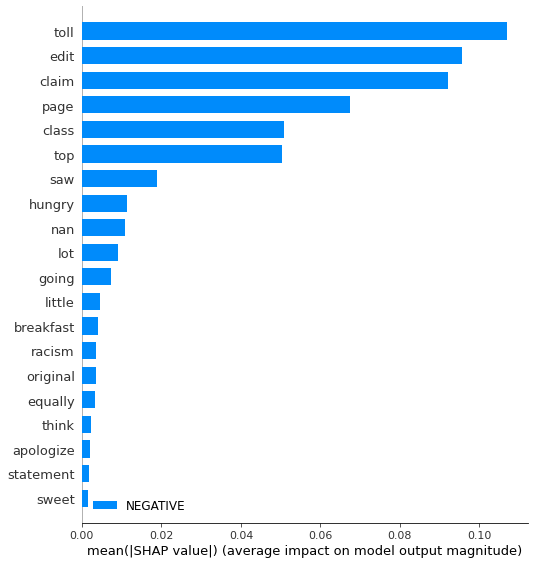

In [28]:
shap.summary_plot(shap_values, feature_names= list(vocab), class_names=["NEGATIVE", "POSITIVE"])

In [30]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0],feature_names= [sentence for sentence in sX_test[:20].values] )